In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"


# plt.rc('axes', titlesize=16)     # fontsize of the axes title
# plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
def get_model_prediction(prms, data, model):
    RT = np.array([])
    SBJ = np.array([])
    Cond = np.array([])

    for i in tqdm(range(prms.sbj.unique().shape[0])):
        sbj = prms.sbj.unique()[i]
        
        delta = prms['delta'].values[i]
        t0_sp = prms['t0_sp'].values[i]
        t0_ac = prms['t0_ac'].values[i]
        
        if model == 'exp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp * np.exp(-lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac * np.exp(-lamda_ac*t)
        elif model == 'hyp':
            b0_sp = prms['b0_sp'].values[i]
            lamda_sp = prms['lambda_sp'].values[i]
            ub_sp = lambda t: b0_sp / (1 + lamda_sp*t)
            
            b0_ac = prms['b0_ac'].values[i]
            lamda_ac = prms['lambda_ac'].values[i]
            ub_ac = lambda t: b0_ac / (1 + lamda_ac*t)
        elif model == 'ddm':
            b0_sp = prms['b0_sp'].values[i]
            b0_ac = prms['b0_ac'].values[i]
            ub_sp = lambda t: b0_sp
            ub_ac = lambda t: b0_ac
            
        lb_sp = lambda t: -1*ub_sp(t)
        lb_ac = lambda t: -1*ub_ac(t)

        sbj_data = data[data['participant']==sbj].reset_index(drop=True)

        rt = []
        cond = []

        for _ in range(300):
            cond.append('SP')
            rt.append(simulate_CDDM(ub_sp, lb_sp, delta, ndt=t0_sp))
            cond.append('AC')
            rt.append(simulate_CDDM(ub_ac, lb_ac, delta, ndt=t0_ac))

        RT = np.concatenate([RT, rt])
        Cond = np.concatenate([Cond, cond])
        SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])

    return pd.DataFrame({'sbj': SBJ,
                         'cond':Cond,
                         'rt': np.abs(RT),
                         'accuracy': RT>0}) 

In [4]:
data = pd.read_csv('../../../_Data/Study2.csv', 
                   index_col=0).reset_index(drop=True)

data = data.sort_values(by=['participant', 'trials', 'event'])

data = data[data['Duration']<data['RT']].reset_index(drop=True)

data['RT']/=1000
data['Duration']/=1000

data_speed = data[data.cue == 'SP'].reset_index(drop=True)
data_accuracy = data[data.cue == 'AC'].reset_index(drop=True)

In [5]:
hyp = pd.read_csv('_prms/hyp.csv')
exp = pd.read_csv('_prms/exp.csv')
jddm = pd.read_csv('_prms/jddm.csv')
bddm= pd.read_csv('_prms/bddm.csv')

In [6]:
hyp.BIC.sum(), exp.BIC.sum(), jddm.BIC.sum(), bddm.BIC.sum()

(-2064.4398779460307,
 -2096.2601118497187,
 -1830.9260985974495,
 5225.491476783476)

In [7]:
hyp.describe()

,b0_sp,lambda_sp,b0_ac,lambda_ac,delta,t0_sp,t0_ac,sigma_sp,sigma_ac,G2,BIC
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.767358,1.307763,0.926063,0.604774,0.541361,0.279187,0.454043,0.301644,0.289995,-129.397238,-82.577595
std,0.279773,1.361114,0.340667,0.536889,0.285216,0.033014,0.058249,0.085696,0.067160,120.827436,120.901202
min,0.500000,0.010000,0.542691,0.010000,0.099685,0.219000,0.328199,0.112654,0.209192,-363.872375,-317.756699
25%,0.572472,0.286670,0.785941,0.200360,0.382163,0.264000,0.415379,0.246177,0.233379,-178.614539,-131.828066
50%,0.629700,0.791474,0.831710,0.491147,0.487755,0.272812,0.457349,0.291935,0.270303,-121.439644,-74.653171
75%,0.885894,1.915275,0.987170,0.789407,0.664120,0.288000,0.488001,0.381539,0.334636,-60.774200,-13.409988
max,1.504480,4.000000,2.298063,1.906614,1.287448,0.387792,0.592622,0.458609,0.470329,161.578939,208.315551


In [8]:
exp.describe()

,b0_sp,lambda_sp,b0_ac,lambda_ac,delta,t0_sp,t0_ac,sigma_sp,sigma_ac,G2,BIC
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.734038,0.809776,0.915365,0.453944,0.543117,0.279316,0.454650,0.301690,0.290401,-130.670048,-83.850404
std,0.265305,0.731035,0.341410,0.321889,0.289331,0.033468,0.058264,0.085349,0.069523,118.204513,118.280903
min,0.500000,0.010000,0.539021,0.010000,0.099730,0.221508,0.320057,0.112649,0.209302,-363.428904,-317.313228
25%,0.572336,0.269557,0.779994,0.205588,0.384226,0.264000,0.415187,0.247533,0.233389,-179.423040,-132.636566
50%,0.616924,0.601638,0.815543,0.364569,0.491543,0.273111,0.457331,0.291943,0.270257,-124.781653,-77.995180
75%,0.854107,1.168402,0.968433,0.627527,0.664901,0.288000,0.487400,0.382698,0.334674,-60.532633,-13.168422
max,1.666360,2.739314,2.328910,1.176804,1.303541,0.392210,0.592001,0.458134,0.487959,137.350936,184.087548


In [9]:
pred_hyp = get_model_prediction(hyp, data, 'hyp')

100%|███████████████████████████████████████████| 25/25 [00:08<00:00,  2.92it/s]


In [10]:
pred_exp = get_model_prediction(exp, data, 'exp')

100%|███████████████████████████████████████████| 25/25 [00:13<00:00,  1.85it/s]


In [11]:
pred_jddm = get_model_prediction(jddm, data, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:07<00:00,  3.25it/s]


In [12]:
pred_bddm = get_model_prediction(bddm, data, 'ddm')

100%|███████████████████████████████████████████| 25/25 [00:08<00:00,  3.10it/s]


In [23]:
def plot_model_pred(pred, var, color, x, label):
    err = scipy.stats.t.ppf(0.975, 25)
    if var == 'rt':
        temp = pred.groupby(by=['sbj'])[var].quantile(0.9)
        plt.errorbar(x= x, 
                     y= pred[var].quantile(0.9),
                     yerr=err*temp.values.std()/np.sqrt(25), 
                     label=label, c=color);
        plt.scatter(x= x, 
                    y= pred[var].quantile(0.9), color=color);
    else:
        temp = pred.groupby(by=['sbj'])[var].mean()
        plt.errorbar(x= x, 
                     y= pred[var].mean(),
                     yerr=err*temp.values.std()/np.sqrt(25), 
                     label=label, c=color);
        plt.scatter(x= x, 
                    y= pred[var].mean(), color=color);

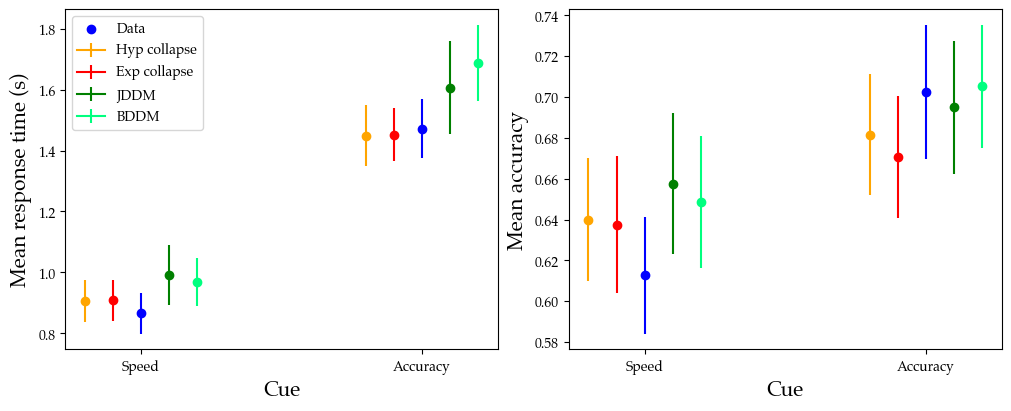

In [24]:
fig = plt.figure(figsize=(10, 4), layout='constrained')
# fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)
plot_model_pred(pred_hyp[pred_hyp['cond']=='SP'], 'rt', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp[pred_exp['cond']=='SP'], 'rt', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm[pred_jddm['cond']=='SP'], 'rt', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm[pred_bddm['cond']=='SP'], 'rt', 'springgreen', 2, 'BDDM')

plot_model_pred(pred_hyp[pred_hyp['cond']=='AC'], 'rt', 'orange', 8, None)
plot_model_pred(pred_exp[pred_exp['cond']=='AC'], 'rt', 'red', 9, None)
plot_model_pred(pred_jddm[pred_jddm['cond']=='AC'], 'rt', 'green', 11, None)
plot_model_pred(pred_bddm[pred_bddm['cond']=='AC'], 'rt', 'springgreen', 12, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['RT'].quantile(0.9)
plt.errorbar(x=0, y=data_speed['RT'].quantile(0.9), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=0, 
            y=data_speed['RT'].quantile(0.9), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['RT'].quantile(0.9)
plt.errorbar(x=10, y=data_accuracy['RT'].quantile(0.9), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=10, 
            y=data_accuracy['RT'].quantile(0.9), 
            c='blue');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean response time (s)', fontsize=15)
plt.legend();
plt.xticks([0, 10], ['Speed', 'Accuracy']);

plt.subplot(122)
plot_model_pred(pred_hyp[pred_hyp['cond']=='SP'], 'accuracy', 'orange', -2, 'Hyp collapse')
plot_model_pred(pred_exp[pred_exp['cond']=='SP'], 'accuracy', 'red', -1, 'Exp collapse')
plot_model_pred(pred_jddm[pred_jddm['cond']=='SP'], 'accuracy', 'green', 1, 'JDDM')
plot_model_pred(pred_bddm[pred_bddm['cond']=='SP'], 'accuracy', 'springgreen', 2, 'BDDM')

plot_model_pred(pred_hyp[pred_hyp['cond']=='AC'], 'accuracy', 'orange', 8, None)
plot_model_pred(pred_exp[pred_exp['cond']=='AC'], 'accuracy', 'red', 9, None)
plot_model_pred(pred_jddm[pred_jddm['cond']=='AC'], 'accuracy', 'green', 11, None)
plot_model_pred(pred_bddm[pred_bddm['cond']=='AC'], 'accuracy', 'springgreen', 12, None)

err = scipy.stats.t.ppf(0.975, 25)
temp = data_speed.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=0, y=data_speed['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=0, 
            y=data_speed['correct'].mean(), 
            c='blue', label='Data');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)

temp = data_accuracy.groupby(by=['participant'])['correct'].mean()
plt.errorbar(x=10, y=data_accuracy['correct'].mean(), 
             yerr=err*temp.values.std()/np.sqrt(25), c='blue');
plt.scatter(x=10, 
            y=data_accuracy['correct'].mean(), 
            c='blue');
plt.xlabel('Cue', fontsize=15)
plt.ylabel('Mean accuracy', fontsize=15)
plt.xticks([0, 10], ['Speed', 'Accuracy']);

plt.savefig('S2_preds.pdf', 
            transparent=True, 
            dpi=600, 
            bbox_inches='tight');